In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter
%matplotlib widget

In [2]:
def randimg(width, height):
    return np.random.randint(0, 255, (height, width), dtype=np.uint8)

In [3]:
def scaledown_ref(img, factor):
    return cv2.resize(img, (0, 0), fx=1./factor, fy=1./factor, interpolation=cv2.INTER_AREA)#(img.shape[1] // factor, img.shape[0] // factor), interpolation=cv2.INTER_AREA)

from schenklern import scaledown as scaledown_native

def scaledown(img, factor):
    height, width = img.shape
    height -= height % factor
    width -= width % factor
    block_x = width // factor
    block_y = height // factor
    small_img = np.zeros((block_y, block_x))
    
    for y in range(height):
        cell_y = y // factor
        for x in range(width):
            cell_x = x // factor
            small_img[cell_y, cell_x] += img[y, x] / factor / factor
    
    for y in range(block_y):
        for x in range(block_x):
            frac = small_img[y, x] - np.floor(small_img[y, x])
            if frac >= 0.5:
                 small_img[y, x] = np.ceil(small_img[y, x])
            else:
                 small_img[y, x] = np.floor(small_img[y, x])
            
    return small_img.astype(np.uint8)

def test_scaledown(scale):
    test = randimg(50, 50)

    # test_ref = scaledown_ref(test, scale)
    test_ref = scaledown(test, scale)
    test_res = scaledown_native(test, scale)

    if np.allclose(test_ref, test_res, atol=1):
        print("PASS")
    else:
        test_ref = test_ref.astype(int)
        test_res = test_res.astype(int)
        print(test_ref)
        print("vs")
        print(test_res)

        print("FAIL")

        plt.figure()
        plt.imshow(test_ref)
        plt.colorbar()
        plt.show()

        plt.figure()
        plt.imshow(test_res)
        plt.colorbar()
        plt.show()

        
        plt.figure()
        plt.imshow(test_ref - test_res)
        plt.colorbar()
        plt.show()

test_scaledown(4)

PASS


In [4]:
def matchTemplate_ref(img, template):
#     return cv2.matchTemplate(img, template, method=cv2.TM_SQDIFF)
    return cv2.matchTemplate(img, template, method=cv2.TM_SQDIFF_NORMED)

def matchTemplate(img, tmp):
    img_h, img_w = img.shape
    tmp_h, tmp_w = tmp.shape
    out_w = img_w - tmp_w + 1
    out_h = img_h - tmp_h + 1
    match = np.zeros((out_h, out_w))
    sum_t = 0.
    for t in tmp.flatten():
        sum_t += float(t)**2
    
    # iterate over template positions
    for match_y in range(out_h):
        for match_x in range(out_w):
            # match template at current position
            sum_i = 0.
            for y in range(tmp_h):
                for x in range(tmp_w):
                    match[match_y, match_x] += (float(tmp[y, x]) - float(img[y + match_y, x + match_x]))**2
                    sum_i += float(img[y + match_y, x + match_x])**2
                    
            factor = 1. / np.sqrt(sum_t * sum_i)
                    
            # normalize on last element
            match[match_y, match_x] *= factor
            
    return match

from schenklern import matchTemplate as matchTemplate_native

def test_matchTemplate(img_w, img_h, tmp_w, tmp_h):
    img = randimg(img_w, img_h)
    img = gaussian_filter(img, sigma=1)
    x = np.random.randint(0, img_w - tmp_w)
    y = np.random.randint(0, img_h - tmp_h)
    tmp = img[y:y+tmp_h, x:x+tmp_w]
    test_ref = matchTemplate_ref(img, tmp)
    test_res = matchTemplate_native(img, tmp)

    if np.allclose(test_ref, test_res, atol=0.000001):
        print("PASS")
    else:
        print(test_ref)
        print("vs")
        print(test_res)
        
        plt.figure()
        plt.imshow(test_ref)
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.imshow(test_res)
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.imshow(test_ref - test_res)
        plt.colorbar()
        plt.show()

        print("FAIL")
        
test_matchTemplate(100, 100, 10, 10)

PASS


In [5]:
def match_frames(img, previous_img, template_width, template_height, offset_x, offset_y):
    # cut out template from old image
    template = previous_img[offset_y:offset_y+template_height, offset_x:offset_x+template_width]

    # match on current image# calculate number of required steps
    divisions = max(2 ** (np.floor(np.log2(min(template_width, template_height))) - 3), 1)

    # resize inputs for initial step
    img_small = cv2.resize(img, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
    template_small = cv2.resize(template, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
    dx, dy = 0, 0

    # first match
    match_img_small = cv2.matchTemplate(img_small, template_small, method=cv2.TM_SQDIFF_NORMED)
    max_idx = np.unravel_index(np.argmin(match_img_small), match_img_small.shape)
        
    # update displacement
    dx = max_idx[1]
    dy = max_idx[0]
    best = match_img_small[max_idx]
    mean = np.mean(match_img_small)

    # iterate over remaining steps
    divisions //= 2
    while divisions >= 1:
        # rescale
        img_small = cv2.resize(img, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
        template_small = cv2.resize(template, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
        
        # adapt indices to new images and template (re)size
        dx *= 2
        dy *= 2

        # cut out image around previous match
        x_min = max(dx - 1, 0)
        x_max = min(dx + 2 + template_small.shape[1], img_small.shape[1] - 1)
        y_min = max(dy - 1, 0)
        y_max = min(dy + 2 + template_small.shape[0], img_small.shape[0] - 1)

        # ensure that size is big enough for template matching
        if y_max - y_min < template_small.shape[0] or x_max - x_min < template_small.shape[1]:
            return dx, dy, 1., 1. / mean
        
        # match
        match_img_small = cv2.matchTemplate(img_small[y_min:y_max, x_min:x_max], template_small, method=cv2.TM_SQDIFF_NORMED)
        max_idx = np.unravel_index(np.argmin(match_img_small), match_img_small.shape)
        
        # update displacement
        dx += max_idx[1] - 1
        dy += max_idx[0] - 1
        best = match_img_small[max_idx]
        
        divisions //= 2
    
    # remove offset
    dx -= offset_x
    dy -= offset_y
    
    if mean == 0:
        mean = 0.0001

    return dx, dy, best, best / mean
    
from schenklern import match_frames as match_frames_native

def test_match_frames(img_w, img_h, tmp_w, tmp_h):
    prev_x_offset = np.random.randint(0, 50)
    prev_y_offset = np.random.randint(0, 50)
    big_img = randimg(img_w + prev_x_offset, img_h + prev_y_offset)
    big_img = gaussian_filter(big_img, sigma=1)
    img = big_img[prev_y_offset:, prev_x_offset:]
    prev_img = big_img[:img_h, :img_w]
    offset_x = np.random.randint(0, img_w - tmp_w)
    offset_y = np.random.randint(0, img_h - tmp_h)

    test_ref = match_frames(img, prev_img, tmp_w, tmp_h, offset_x, offset_y)
    test_res = match_frames_native(img, prev_img, tmp_w, tmp_h, offset_x, offset_y)

    if np.allclose(test_ref, test_res, atol=0.00001):
        print("PASS")
    else:
        print(test_ref)
        print("vs") 
        print(test_res)

        print("FAIL")
        
test_match_frames(320, 256, 64, 64)

PASS


In [6]:
def img_flow(img, previous, template_width, template_height):
    # pre-calculate possible template offsets
    height, width = img.shape
    offset_x = width - template_width
    offset_y = height - template_height

    # match all corners
    dx_ul, dy_ul, best_ul, snr_ul = match_frames(img, previous, template_width, template_height, 0, 0)
    dx_ur, dy_ur, best_ur, snr_ur = match_frames(img, previous, template_width, template_height, offset_x, 0)
    dx_ll, dy_ll, best_ll, snr_ll = match_frames(img, previous, template_width, template_height, 0, offset_y)
    dx_lr, dy_lr, best_lr, snr_lr = match_frames(img, previous, template_width, template_height, offset_x, offset_y)

    # select best match
    best = np.argmin([best_ul, best_ur, best_ll, best_lr])
    if best == 0:
        dx, dy, best, current_snr = dx_ul, dy_ul, best_ul, snr_ul
    elif best == 1:
        dx, dy, best, current_snr = dx_ur, dy_ur, best_ur, snr_ur
    elif best == 2:
        dx, dy, best, current_snr = dx_ll, dy_ll, best_ll, snr_ll
    else:
        dx, dy, best, current_snr = dx_lr, dy_lr, best_lr, snr_lr

    return dx, dy, best, current_snr
    
from schenklern import img_flow as img_flow_native

def test_img_flow(img_w, img_h, tmp_w, tmp_h):
    prev_x_offset = np.random.randint(0, 50)
    prev_y_offset = np.random.randint(0, 50)
    big_img = randimg(img_w + prev_x_offset, img_h + prev_y_offset)
    big_img = gaussian_filter(big_img, sigma=1)
    img = big_img[prev_y_offset:, prev_x_offset:]
    prev_img = big_img[:img_h, :img_w]
    test_ref = img_flow(img, prev_img, tmp_w, tmp_h)
    test_res = img_flow_native(img, prev_img, tmp_w, tmp_h)

    if np.allclose(test_ref, test_res, atol=0.00001):
        print("PASS")
    else:
        print(test_ref)
        print("vs")
        print(test_res)

        print(prev_x_offset, prev_y_offset)

        print("FAIL")
        
test_img_flow(100, 100, 10, 10)

PASS


In [7]:
def in_range(lower, value, upper):
    lower_bound = min(lower, upper)
    upper_bound = max(lower, upper)
    
    return (lower_bound <= value) and (value <= upper_bound)
    
from schenklern import in_range as in_range_native

def test_in_range():
    upper_bound = np.random.randint(10, 50)
    lower_bound = upper_bound - 5
    is_in_range = upper_bound - 2
    is_not_in_range = upper_bound + 3
    test_ref1 = in_range(lower_bound, is_in_range, upper_bound)
    test_ref2 = in_range(lower_bound, is_not_in_range, upper_bound)
    test_res1 = in_range_native(lower_bound, is_in_range, upper_bound)
    test_res2 = in_range_native(lower_bound, is_not_in_range, upper_bound)

    if test_ref1 == test_res1 and test_ref2 == test_res2:
        print("PASS")
    else:
        print("FAIL")
        
test_in_range()

PASS


In [8]:
def check_frameskip(x, prev_x):
    # only act when going above minimum speed
    if np.abs(prev_x) < 10 and np.abs(x) < 10:
        return 0
    
    # check for correct value
    if in_range(prev_x * 0.8, x, prev_x * 1.2):
        return 0
    
    # check for frame skip
    elif in_range(prev_x * 1.8, x, prev_x * 2.2):
        return 1
    
    # check for physically implausible movement
    else:
        return 4

from schenklern import check_frameskip as check_frameskip_native

def test_check_frameskip():
    prev_x = np.random.randint(10, 50)
    x1 = 0.99 * prev_x
    x2 = 2.001 * prev_x
    x3 = prev_x * 3
    test_ref0 = check_frameskip(1, 1)
    test_ref1 = check_frameskip(x1, prev_x)
    test_ref2 = check_frameskip(x2, prev_x)
    test_ref3 = check_frameskip(x3, prev_x)
    test_res0 = check_frameskip_native(1, 1)
    test_res1 = check_frameskip_native(x1, prev_x)
    test_res2 = check_frameskip_native(x2, prev_x)
    test_res3 = check_frameskip_native(x3, prev_x)

    if test_ref0 == test_res0 and test_ref1 == test_res1 and test_ref2 == test_res2 and test_ref3 == test_res3:
        print("PASS")
    else:
        print("FAIL")
        
test_check_frameskip()

PASS


In [9]:
def remove_outliers(u, v, prev_u, prev_v, best, snr):
    frameskip_u = check_frameskip(u, prev_u)
    frameskip_v = check_frameskip(v, prev_v)
    
    # check for bad match
    if best > 0.1:
        return 3, prev_u, prev_v

    # check signal to noise ratio
    if snr > 0.1:
        return 2, prev_u, prev_v
    
    # check for physically implausible movement
    if frameskip_u == 4 or frameskip_v == 4:
        return 4, prev_u, prev_v
    
    # check for frameskips
    if frameskip_u == 1 or frameskip_v == 1:
        return 1, u // 2, v // 2
    
    return 0, u, v

from schenklern import remove_outliers as remove_outliers_native

def test_remove_outliers():
    prev_x = np.random.randint(10, 50)
    prev_y = np.random.randint(10, 50)
    x1 = int(0.99 * prev_x)
    y1 = int(0.99 * prev_y)
    x2 = int(2.001 * prev_x)
    y2 = int(2.001 * prev_y)
    x3 = int(prev_x * 3)
    y3 = int(prev_y * 3)
    best_good = 0.
    snr_good = 0.
    best_bad = 0.4
    snr_bad = 0.5
    test_ref0 = remove_outliers(1, 1, 1, 1, best_good, snr_good)
    test_ref1 = remove_outliers(x1, prev_x, y1, prev_y, best_good, snr_good)
    test_ref2 = remove_outliers(x2, prev_x, y2, prev_y, best_good, snr_good)
    test_ref3 = remove_outliers(x3, prev_x, y3, prev_y, best_good, snr_good)
    test_ref4 = remove_outliers(x1, prev_x, y1, prev_y, best_bad, snr_good)
    test_ref5 = remove_outliers(x1, prev_x, y1, prev_y, best_good, snr_bad)
    test_res0 = remove_outliers_native(1, 1, 1, 1, best_good, snr_good)
    test_res1 = remove_outliers_native(x1, prev_x, y1, prev_y, best_good, snr_good)
    test_res2 = remove_outliers_native(x2, prev_x, y2, prev_y, best_good, snr_good)
    test_res3 = remove_outliers_native(x3, prev_x, y3, prev_y, best_good, snr_good)
    test_res4 = remove_outliers_native(x1, prev_x, y1, prev_y, best_bad, snr_good)
    test_res5 = remove_outliers_native(x1, prev_x, y1, prev_y, best_good, snr_bad)

    if test_ref0 == test_res0 and test_ref1 == test_res1 and test_ref2 == test_res2 and test_ref3 == test_res3 and test_ref4 == test_res4 and test_ref5 == test_res5:
        print("PASS")
    else:
        print("FAIL")
        
test_remove_outliers()

PASS


In [10]:
# load all images files from selected directory in ascending order and convert them to grayscale
img_dir = "../data/videok7"
imgs = [i for i in os.listdir(img_dir) if i[-4:] == ".png" ]
imgs = sorted(imgs)
imgs = [cv2.cvtColor(cv2.imread(img_dir + "/" + i), cv2.COLOR_BGR2GRAY) for i in imgs if int(i[-9:-4]) in range(0, 2000)]

In [25]:
from tqdm import tqdm

from schenklern import scaledown as sdn
from schenklern import matchTemplate as mtn

def sdc(img, divisions):
    return cv2.resize(img, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)

def mtc(img, tmp):
    return cv2.matchTemplate(img, tmp, method=cv2.TM_SQDIFF_NORMED)

def sd(img, divisions):
    n = sdn(img, divisions)
    c = sdc(img, divisions)

    if not np.allclose(n, c):
        plt.figure()
        plt.imshow(c)
        plt.colorbar()
        plt.show()

        plt.figure()
        plt.imshow(n)
        plt.colorbar()
        plt.show()

        plt.figure()
        plt.imshow(c - n)
        plt.colorbar()
        plt.show()

        raise Exception("wrong scaling")
    
    return n

def mt(img, tmp):
    return mtn(img, tmp)

In [29]:
def match_frames(img, previous_img, template_width, template_height, offset_x, offset_y):
    # cut out template from old image
    template = previous_img[offset_y:offset_y+template_height, offset_x:offset_x+template_width]

    # match on current image# calculate number of required steps
    divisions = int(max(2 ** (np.floor(np.log2(min(template_width, template_height))) - 3), 1))
    
    # resize inputs for initial step
    img_small = sd(img, divisions)
    # img_small = cv2.resize(img, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
    # template_small = cv2.resize(template, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
    template_small = sd(template, divisions)
    dx, dy = 0, 0

    # first match
    match_img_small = mt(img_small, template_small)
    # match_img_small = cv2.matchTemplate(img_small, template_small, method=cv2.TM_SQDIFF_NORMED)

    max_idx = np.unravel_index(np.argmin(match_img_small), match_img_small.shape)
        
    # update displacement
    dx = max_idx[1] - 1
    dy = max_idx[0] - 1
    best = match_img_small[max_idx]


    # max_idx = np.argmin(match_img_small)
    # dy, dx = np.unravel_index(max_idx, match_img_small.shape)
    # best = match_img_small[max_idx]
    mean = np.mean(match_img_small)
    
    # iterate over remaining steps
    divisions //= 2
    while divisions >= 1:
        # rescale
        img_small = sd(img, divisions)
        template_small = sd(template, divisions)

        # img_small = cv2.resize(img, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
        # template_small = cv2.resize(template, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
        
        # adapt indices to new images and template (re)size
        dx *= 2
        dy *= 2
        
        # cut out image around previous match
        x_min = max(dx - 1, 0)
        x_max = min(dx + 2 + template_small.shape[1], img_small.shape[1] - 1)
        y_min = max(dy - 1, 0)
        y_max = min(dy + 2 + template_small.shape[0], img_small.shape[0] - 1)

        # ensure that size is big enough for template matching
        if y_max - y_min < template_small.shape[0] or x_max - x_min < template_small.shape[1]:
            return dx, dy, 1., 1. / mean
        
        # match
        match_img_small = mt(img_small[y_min:y_max, x_min:x_max], template_small)

        # match_img_small = cv2.matchTemplate(img_small[x_min:x_max, y_min:y_max], template_small, method=cv2.TM_SQDIFF_NORMED)
        max_idx = np.unravel_index(np.argmin(match_img_small), match_img_small.shape)
        
        # update displacement
        dx += max_idx[1] - 1
        dy += max_idx[0] - 1
        best = match_img_small[max_idx]
        
        divisions //= 2
    
    # remove offset
    dx -= offset_x
    dy -= offset_y
    
    if mean == 0:
        mean = 0.0001
    
    return dx, dy, best, best / mean

# from schenklern import match_frames

def img_flow(img, previous, template_width, template_height):
    # pre-calculate possible template offsets
    height, width = img.shape
    offset_x = width - template_width
    offset_y = height - template_height

    # match all corners
    dx_ul, dy_ul, best_ul, snr_ul = match_frames(img, previous, template_width, template_height, 0, 0)
    dx_ur, dy_ur, best_ur, snr_ur = match_frames(img, previous, template_width, template_height, offset_x, 0)
    dx_ll, dy_ll, best_ll, snr_ll = match_frames(img, previous, template_width, template_height, 0, offset_y)
    dx_lr, dy_lr, best_lr, snr_lr = match_frames(img, previous, template_width, template_height, offset_x, offset_y)

    # select best match
    best = np.argmin([best_ul, best_ur, best_ll, best_lr])
    if best == 0:
        dx, dy, best, current_snr = dx_ul, dy_ul, best_ul, snr_ul
    elif best == 1:
        dx, dy, best, current_snr = dx_ur, dy_ur, best_ur, snr_ur
    elif best == 2:
        dx, dy, best, current_snr = dx_ll, dy_ll, best_ll, snr_ll
    else:
        dx, dy, best, current_snr = dx_lr, dy_lr, best_lr, snr_lr

    return dy, dx ,best, current_snr
    
# from schenklern import img_flow

def in_range(lower, value, upper):
    lower_bound = min(lower, upper)
    upper_bound = max(lower, upper)
    
    return lower_bound <= value and value <= upper_bound

def check_frameskip(x, prev_x):
    # only act when going above minimum speed
    if np.abs(prev_x) < 10 and np.abs(x) < 10:
        return 0
    
    # check for correct value
    if in_range(prev_x * 0.8, x, prev_x * 1.2):
        return 0
    
    # check for frame skip
    elif in_range(prev_x * 1.8, x, prev_x * 2.2):
        return 1
    
    # check for physically implausible movement
    else:
        return 4

def remove_outliers(u, v, prev_u, prev_v, best, snr):
    frameskip_u = check_frameskip(u, prev_u)
    frameskip_v = check_frameskip(v, prev_v)
    
    # check for bad match
    if best > 0.1:
        return 3, prev_u, prev_v

    # check signal to noise ratio
    if snr > 0.1:
        return 2, prev_u, prev_v
    
    # check for physically implausible movement
    if frameskip_u == 4 or frameskip_v == 4:
        return 4, prev_u, prev_v
    
    # check for frameskips
    if frameskip_u == 1 or frameskip_v == 1:
        return 1, u // 2, v // 2
    
    return 0, u, v

def flow_all(imgs, template_width, template_height):
    # allocate output arrays
    u = [0]
    v = [0]
    new_u = [0]
    new_v = [0]
    prev_dy = 0
    prev_dx = 0
    best_matches = []
    snr = []
    outliers = []
    
    # pre-calculate possible template offsets
    width, height = imgs[0].shape
    offset_x = width - template_width
    offset_y = height - template_height
    
    # initialize loop variables
    previous = imgs[0]
    
    # iterate over all images
    for i in tqdm(range(1, len(imgs))):
        img = imgs[i]
        
        # calculate flow and filter outliers
        dy, dx, best, current_snr = img_flow(img, previous, template_width, template_height)
        outlier, new_u_current, new_v_current = remove_outliers(dy, dx, prev_dy, prev_dx, best, current_snr)
        
        # store temporary results
        prev_dx = new_v_current
        prev_dy = new_u_current
        
        # store relevant results
        u += [dy]
        v += [dx]
        best_matches += [best]
        snr += [current_snr]
        new_u += [new_u_current]
        new_v += [new_v_current]
        outliers += [outlier]
        
        # duplicate result if frame was skipped
#         if outlier == 1:
#             new_u += [new_u_current]
#             new_v += [new_v_current]
#             outliers += [outlier]
        
        previous = img
        
    return u, v, new_u, new_v, outliers, best_matches, snr

In [30]:
from tqdm import tqdm
from schenklern import img_flow as img_flow_native
from schenklern import remove_outliers as remove_outliers_native

def flow_all_native(imgs, template_width, template_height):
    # allocate output arrays
    u = [0]
    v = [0]
    new_u = [0]
    new_v = [0]
    prev_dy = 0
    prev_dx = 0
    best_matches = []
    snr = []
    outliers = []
    
    # initialize loop variables
    previous = imgs[0]
    
    # iterate over all images
    for i in tqdm(range(1, len(imgs))):
        img = imgs[i]
        
        # calculate flow and filter outliers
        dy, dx, best, current_snr = img_flow_native(img, previous, template_width, template_height)
        outlier, new_u_current, new_v_current = remove_outliers_native(dy, dx, prev_dy, prev_dx, best, current_snr)
        
        # store temporary results
        prev_dx = new_v_current
        prev_dy = new_u_current
        
        # store relevant results
        u += [dy]
        v += [dx]
        best_matches += [best]
        snr += [current_snr]
        new_u += [new_u_current]
        new_v += [new_v_current]
        outliers += [outlier]
        
        # duplicate result if frame was skipped
#         if outlier == 1:
#             new_u += [new_u_current]
#             new_v += [new_v_current]
#             outliers += [outlier]
        
        previous = img
        
    return u, v, new_u, new_v, outliers, best_matches, snr

In [31]:
t0 = time.perf_counter()
u, v, new_u, new_v, outliers, best_matches, snr = flow_all(imgs, 64, 64)
t1 = time.perf_counter()
print(len(u) / (t1 - t0), "FPS")

100%|██████████| 1998/1998 [00:22<00:00, 88.90it/s] 

88.91463365625002 FPS


In [32]:
# t0 = time.perf_counter()
# u, v, new_u, new_v, outliers, best_matches, snr = flow_all_native(imgs, 64, 64)
# t1 = time.perf_counter()
# print(len(u) / (t1 - t0), "FPS")

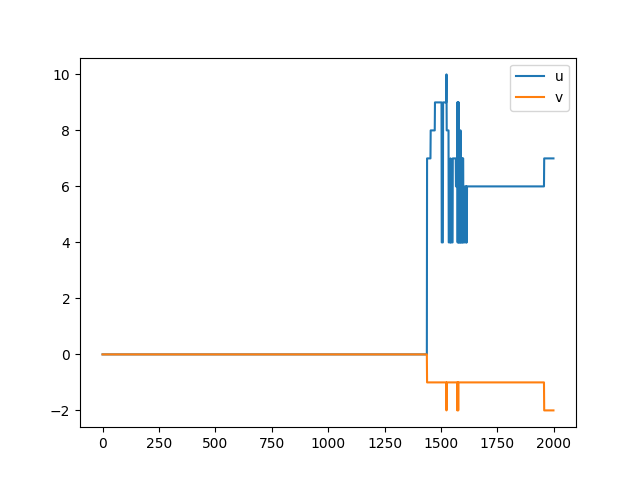

In [33]:
plt.figure()
plt.plot(np.array(new_u), label="u")
plt.plot(np.array(new_v), label="v")
# plt.plot(np.array(outliers)*100, label="outlier")
# plt.plot(np.array(best_matches)*10000, label="best")
# plt.plot(np.array(snr)*100, label="snr")
plt.legend()
plt.show()

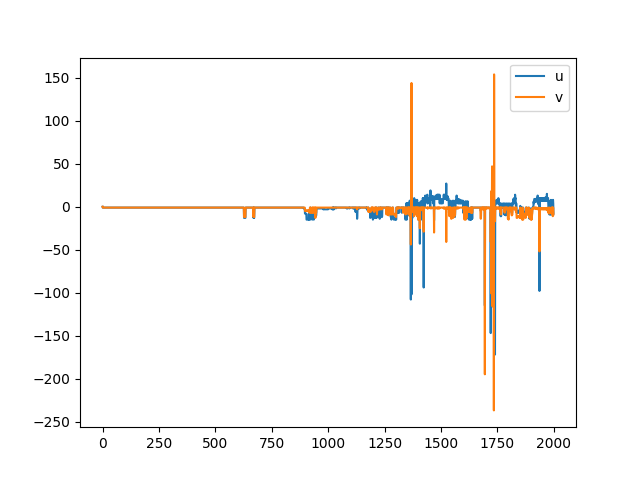

In [34]:
plt.figure()
plt.plot(np.array(u), label="u")
plt.plot(np.array(v), label="v")
# plt.plot(np.array(outliers)*100, label="outlier")
plt.legend()
plt.show()

In [35]:
def median_filter(x, w):
    reshapable_x = x[:x.shape[0]-x.shape[0]%w]
    reshaped_x = reshapable_x.reshape((reshapable_x.shape[0]//w, w))
    return np.median(reshaped_x, axis=1) * w
final_u = median_filter(np.array(new_u), 5)
final_v = median_filter(np.array(new_v), 5)

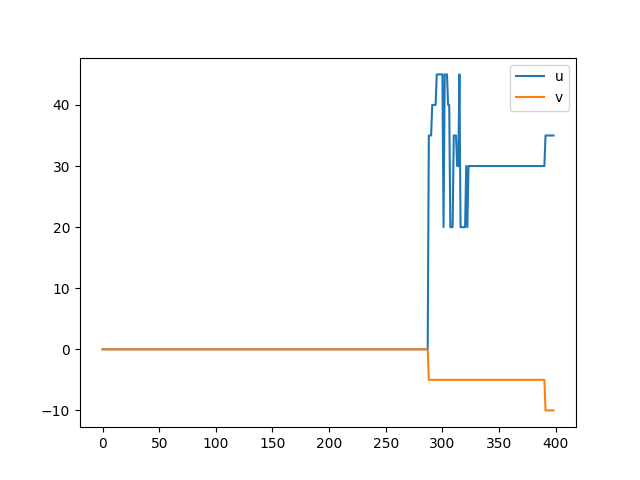

In [36]:
plt.figure()
plt.plot(final_u, label="u")
plt.plot(final_v, label="v")
plt.legend()
plt.show()

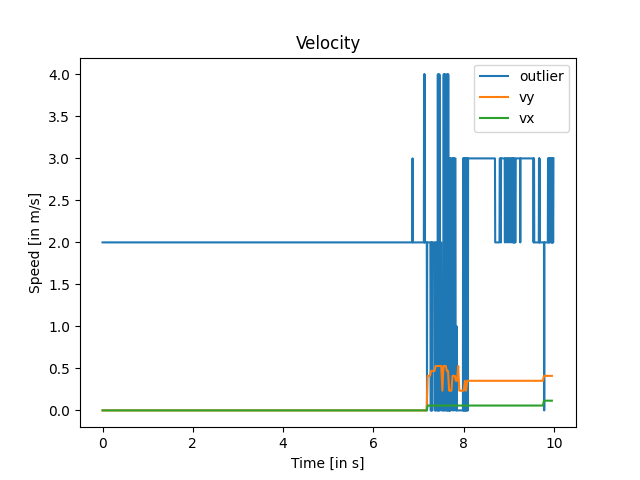

In [37]:
plt.figure()
plt.plot(np.arange(0, (len(new_u) - 1) / 200, 1 / 200.), np.array(outliers), label="outlier")
plt.plot(np.arange(0, len(final_u) / (200//5), 1 / (200./5)), np.array(final_u) * 0.094 / 320. * (200./5), label="vy")
plt.plot(np.arange(0, len(final_u) / (200//5), 1 / (200./5)), -np.array(final_v) * 0.074 / 256. * (200./5), label="vx")
plt.xlabel("Time [in s]")
plt.ylabel("Speed [in m/s]")
plt.title("Velocity")
plt.legend()
plt.show()